Summary:
- Light GBM is better than linear regression, in terms of cross-validation error

In [2]:
from assess_property.fit_learner import MakeExperiment

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from scipy.stats import describe

# Make experiment

In [4]:
_, experiment = MakeExperiment()

100%|██████████| 10/10 [00:13<00:00,  1.37s/it]


<class 'pandas.core.frame.DataFrame'>
Int64Index: 305699 entries, 9 to 1731182
Data columns (total 9 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   PID                           305699 non-null  object 
 1   YR_BUILT                      305669 non-null  float64
 2   LIVING_AREA                   305692 non-null  float64
 3   LU                            305699 non-null  object 
 4   ZIPCODE                       305699 non-null  object 
 5   TOTAL_VALUE                   305699 non-null  float64
 6   YEAR                          305699 non-null  int64  
 7   YR_REMODEL                    37158 non-null   float64
 8   TOTAL_VALUE_IN_HUNDRED_GRAND  305699 non-null  float64
dtypes: float64(5), int64(1), object(3)
memory usage: 23.3+ MB


# Compare linear regression with light GBM 

## Linear regression

In [5]:
lm_cs_res = experiment.cv_fit(learner = "lm")

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    1.2s finished


Average absolute error is about $\$270,000$.

In [6]:
print(lm_cs_res["test_neg_mean_absolute_error"])

[-2.74840018 -2.7654714  -2.75283539 -2.7328734  -2.73299919 -2.7386912
 -2.74810052 -2.75444437 -2.75534832 -2.79182196]


Average absolute percentage error is about $50\%$

In [7]:
print(lm_cs_res["test_neg_mean_absolute_percentage_error"])

[-0.52438105 -0.52518303 -0.52697512 -0.51755901 -0.52022079 -0.52264144
 -0.51685518 -0.52375622 -0.52681537 -0.52415252]


## Light GBM

In [8]:
lgbm_cs_res = experiment.cv_fit(learner = "lgbm")

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    3.0s finished


Average absolute error is about $\$160,000$.
There is clearly a benefit compared to using linear model.

In [9]:
print(lgbm_cs_res["test_neg_mean_absolute_error"])

[-1.6079664  -1.61104946 -1.62638593 -1.59375571 -1.61172653 -1.61218939
 -1.623267   -1.60029769 -1.617158   -1.63463059]


Average absolute percentage error is about $27\%$

In [10]:
print(lgbm_cs_res["test_neg_mean_absolute_percentage_error"])

[-0.27831531 -0.27741642 -0.27947643 -0.2760934  -0.27791369 -0.27782083
 -0.27571262 -0.27711892 -0.27933788 -0.27604633]


In [11]:
lgbm_cs_res.keys()

dict_keys(['fit_time', 'score_time', 'estimator', 'indices', 'test_neg_mean_absolute_error', 'test_neg_root_mean_squared_error', 'test_neg_mean_absolute_percentage_error'])

### Visualize errors as boxplots

In [18]:
dflist = []
for prefix in ["lm", "lgbm"]:
    name = "%s_cs_res" %prefix
    d_ = {key: val for (key,val) in locals()[name].items() if ((key != "estimator") and (key != "indices")) }
    tempdf = pd.DataFrame.from_dict(d_)
    tempdf["learner"] = name
    tempdf["fold_idx"] = tempdf.index
    dflist.append(tempdf)
errdf = pd.concat(dflist).reset_index(drop=True)

errdf = pd.wide_to_long(df = errdf,
                stubnames="test",
                i = ["learner","fold_idx"],
                j = "score_type",
                sep='_', 
                suffix=r'\w+').reset_index()
errdf.rename(columns = {"test": "error"}, inplace=True)
errdf["error"] = -errdf["error"]
errdf["error_type"] = errdf["score_type"].apply(lambda x: "_".join(x.split("_")[1:]))

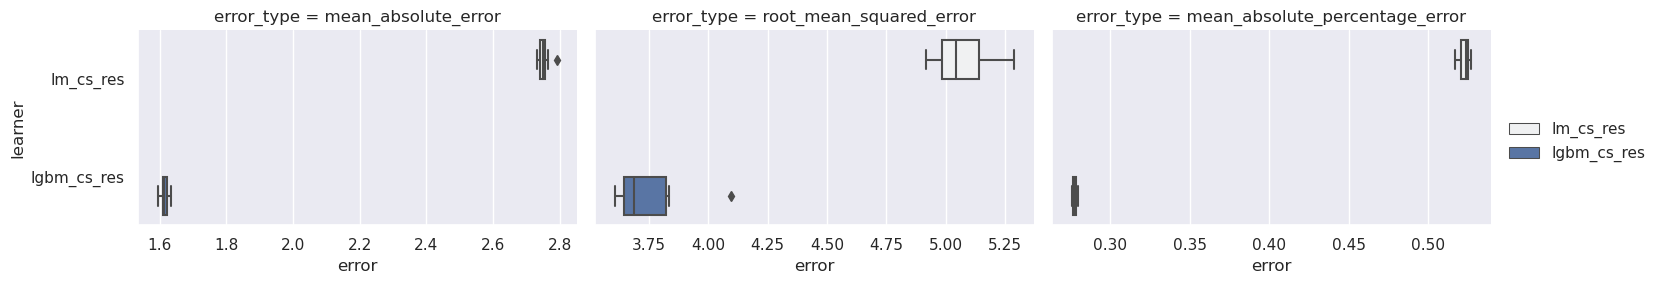

In [19]:
sns.set(font_scale = 1.0)
g = sns.FacetGrid(data = errdf,
                  height = 3,
                  aspect =1.7,
                  col="error_type",
                  sharex=False)

g.map_dataframe(sns.boxplot,
                x = "error",
                y = "learner",
                hue = "learner")
g.add_legend()
plt.savefig("../figures/cverrors.jpg")
plt.show()